In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import copy 
import seaborn as sns

# Setting font parameters for graphs
plt.rcParams['font.family'] = 'Roboto'
plt.rcParams['font.serif'] = 'Roboto'
plt.rcParams['font.monospace'] = 'Roboto Mono'
plt.rcParams['font.size'] = 14

In [2]:
def sigmoid(x):
    """
    This function computes the sigmoid function for each element.
    Args:
        x (np.array): the array to which we want to apply a sigmoid function.
    Returns:
        np.array: the array transformed through the sigmoid function.
    """
    return 1/(1+np.exp(-x))

def relu(x):
    """
    This function computes the ReLU function for each element.
    Args:
        x (np.array): the array to which we want to apply the ReLU function.
    Returns:
        np.array: the array transformed through the ReLU function.
    """
    return np.maximum(0,x)

def tanh(vector):
    """
    This function computes the tanh function for each element.
    Args:
        x (np.array): the array to which we want to apply the tanh function.
    Returns:
        np.array: the array transformed through the tanh function.
    """
    return np.tanh(x)

In [3]:
def beautiful_plot(ax,title,xtitle,ytitle,title_size=21,x_size=18,y_size=18,angle=0, name = None):
    """
    This function changes some visual properties of the plot, and saves the figure as a png.
    """
    sns.despine(bottom = False, left = False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    plt.title(title,fontsize = title_size, pad = 15)
    plt.xlabel(xtitle,fontsize = x_size, labelpad = 10)
    plt.ylabel(ytitle,fontsize = y_size, labelpad = 10)

    plt.xticks(rotation = angle)
    if name != None:
        plt.savefig('../figures/'+name+'.png', transparent=False, bbox_inches='tight', pad_inches=0.2)
    
    return

# Loading the dataset

In [4]:
# Reading the files with the images
train = h5py.File('../data/train.h5','r+')   
test = h5py.File('../data/test.h5','r+') 

# Transforming to arrays
train_x_orig = np.array(train.get('train_set_x'))
train_y = np.array(train.get('train_set_y')).reshape(1,-1)
test_x_orig = np.array(test.get('test_set_x'))
test_y = np.array(test.get('test_set_y')).reshape(1,-1)

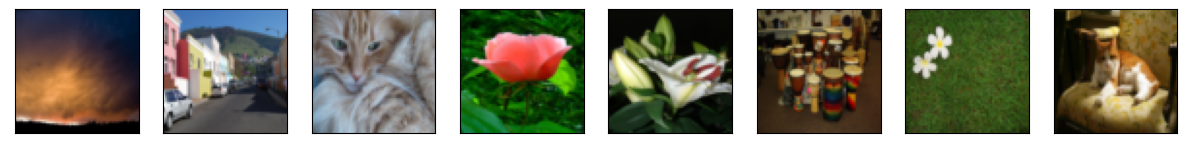

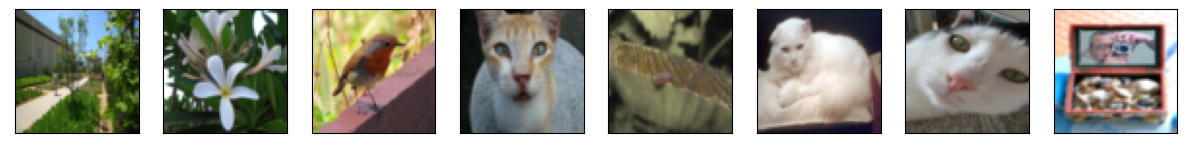

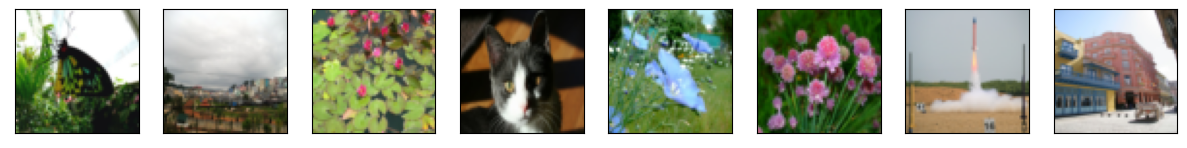

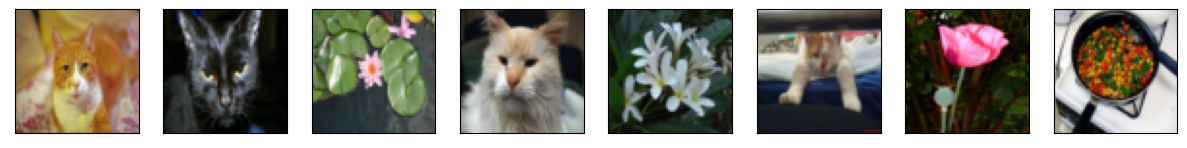

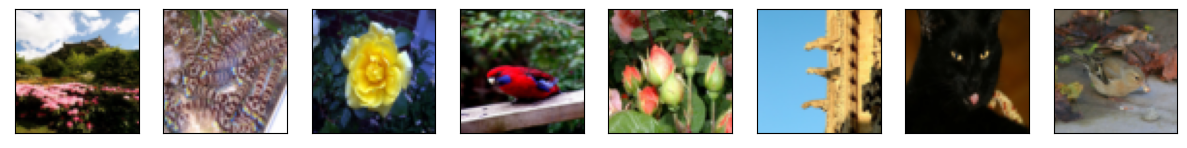

In [5]:
# Visualizing the dataset: example of 40 pictures
count = 0
for i in range(1,6):
    fig, ax = plt.subplots(1, 8,figsize=(15,15))
    for j in range (1,9):
        image = Image.fromarray(train_x_orig[count])
        ax[j-1].imshow(image)
        ax[j-1].set_xticks([])
        ax[j-1].set_yticks([])
        count += 1
plt.show()

In [6]:
# Flattening X
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0],-1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0],-1).T

# Normalizing the variables
train_x = train_x_flatten/255
test_x = test_x_flatten/255

# Initializing a model

In [7]:
def initialize_parameters(input_, n_h, output_, act):
    """
    This function initializes the model by creating a dictionary with random
    weights W1,W2... and zeros b1,b2... and return them as a dictionary.
    Args:
        input_ (np.array): independant variables X.
        n_h (list): the number of units per hidden layer .
        output_ (np.array): our problem's target Y.
    
    Returns:
        parameters (dict): dictionary containing:
            W1 -- matrix with weights from layer 1. 
            b1 -- vector with biases from layer 1.
            ......................................
            W_max -- matrix of weights from last layer. 
            b_max -- vector of biases from last layer.
            act --  list of activation functions.
    """  
    
    # We start by computing the shapes of the input and output.
    n_x = input_.shape[0]
    n_y = output_.shape[0]
    
    # Concatenating them  with the hidden layers shapes.
    list_ =[n_x]+n_h+[n_y]
    
    parameters = {}
    # Creating a dictionary of the 'W's and 'b's with the proper shapes. 
    for i in range(len(list_)-1):
        parameters['W'+str(i+1)] = np.random.randn(list_[i+1],list_[i])/np.sqrt(list_[i]) # We divide  the initial weights
                                                                                          # to make them close to zero.
        parameters['b'+str(i+1)] = np.zeros((list_[i+1],1))
    
    # Creating a last pair key-value containing the list of activation functions for each layer. 
    parameters['act'] = act
    
    # Making sure the length of the layers and the activation functions are compatible.
    assert (len(n_h)+1 == len(act))
    return parameters

# Forward propagation

In [8]:
def forward_propagation(X, parameters):
    """
    This function computes all the activation values for all layers
    through forward propagation, and returns them.
    
    Args:
        X (np.array): independant variables X.
        parameters (dict): values that define the neural network.
    
    Returns:
        output (np.array): the activation values for the last layer. 
        cache (dict): dictionary containing:
            Z1 -- linear values of layer 1. 
            A1 -- activation values of layer 1.
            ......................................
            Z_max -- linear values of last layer. 
            A_max -- activation values of last layer.
    """  
    # Initializing the dictionary, extracting X, and the activation functions.
    cache = {}
    cache['A0'] = X
    act = parameters['act']
    
    # Forward propagation (iterating for each hidden layer)
    for layer in range(len(act)):
        # Extracting the parameters of this layer.
        W = parameters['W'+str(layer+1)]
        b = parameters['b'+str(layer+1)]
        activation = act[layer]
        
        # Computing the activation values of the previous layer.
        A_old = cache['A'+str(layer)] 
        
        # Computing the linear values of the current layer.
        Z_l = np.matmul(W,A_old)+b 
        # And storing them
        cache['Z'+str(layer+1)] = Z_l
        
        # Computing the activation values of the current layer.
        if activation == 'relu':
            output = relu(Z_l)
        elif activation == 'sigmoid':
            output = sigmoid(Z_l)
        # And storing them.
        cache['A'+str(layer+1)] = output
    
    return output, cache

In [9]:
def compute_loss(AL, Y, parameters, lambd):
    """
    This function computes the total cost function for some predictions.
    
    Args:
        AL (np.array): the activation values of the last layer.
        Y (np.array): the real values of our target. 
        lambd (float): the value of lambda in regularization.
        
    Returns:
        float: the value of the cost function.
    """
    m = Y.shape[1]
    n_layers = len(parameters['act'])
    
    # We first compute the loss of each sample
    loss = -(Y*np.log(AL+1e-20)+(1-Y)*np.log(1-AL+10e-20))
    # and then compute their mean (which is the cost)
    cross_entropy_cost = np.squeeze(1/m*np.sum(loss))
    
    # We now compute the part associate with regularization:
    regu_cost_vector = [np.sum(np.multiply(parameters['W'+str(layer)],parameters['W'+str(layer)])) for layer in range(1,n_layers+1)]
    regu_cost = lambd/(2*m)*np.sum(regu_cost_vector)
    
    # We finally compute the total cost
    J = cross_entropy_cost + regu_cost
    return J

In [10]:
def predict(X, parameters, threshold = 0.5):
    """
    This function predicts the target using our model. 
    
    Args:
        X (np.array): the independant variables X
        parameters (dict): the parameters of the model. 
        threshold (float): the threshold to predict 1. 
        
    Returns:
        np.array: the predictions for each sample.
    """
    # We first compute the activation values
    AL,cache = forward_propagation(X, parameters)
    
    # And then compute the predictions using a threshold
    prediction = np.where(AL>=threshold,1,0)
    
    return prediction

In [11]:
def relu_derivate(x):
    """
    This function computes the derivate d(ReLU(x))/dx.
    
    Args:
        x (np.array): an array of the values x. 
        
    Returns:
        np.array: an array of the derivates. 
    """
    # If x > 0, the derivate is equal to 1.
    x[x>0] = 1
    # If x < 0, the derivate is equal to 0.
    x[x<=0] = 0
    return x

# Backward propagation

In [12]:
def backward_prop(cache, parameters, Y):
    """
    This function computes the gradients of all the parameters
    through backward propagation, and returns them. 
    
    Args:
        cache (dict): linear and activation values of each layer.
        parameters (dict): values that define the neural network.
        Y (np.array): the values of the target for our training.
    
    Returns:
        grads (dict): dictionary containing:
            dZ1 -- derivates of Z1.
            dW1 -- derivates of W1.
            db1 -- derivates of b1.
            ......................................
            dZ_max -- derivates of Z_max.
            dW_max -- derivates of W_max.
            db_max -- derivates of b_max.
    """  
    X = cache['A0']
    m = Y.shape[1]
    grads = {}
    
    # ---------- LAYER L ----------
    # We start with the last layer
    act = parameters['act']
    nlayer = len(act)

    # Extracting the values of this layer
    AL = cache['A'+str(nlayer)]
    ZL = cache['Z'+str(nlayer)]
    
    # Computing dZ
    if act[nlayer-1] == 'sigmoid':
        dZL = AL-Y
    else:
        raise Exception("No code for non-sigmoid output layers")
    # Storing the value in the dictionary
    grads['dZ'+str(nlayer)] = dZL

    # Computing dW
    A_prev = cache['A'+str(nlayer-1)]
    dWL = 1/m*np.matmul(dZL,A_prev.T)
    assert (dWL.shape == parameters['W'+str(nlayer)].shape)
    # Storing the value
    grads['dW'+str(nlayer)] = dWL
    
    # Computing db
    dBL = 1/m*np.sum(dZL,axis=1,keepdims=True)
    assert (dBL.shape == parameters['b'+str(nlayer)].shape)
    # Storing the value
    grads['db'+str(nlayer)] = dBL

    # ---------- from LAYER L-1 to LAYER 1 ----------
    for layer in reversed(range(1,len(act))):
        
        # Extracting the values of this layer
        Zl = cache['Z'+str(layer)]
        Wl_last = parameters['W'+str(layer+1)]
        dZ_last = grads['dZ'+str(layer+1)]
        A_old = cache['A'+str(layer-1)]
        
        # Computing dZ
        if act[layer-1]=='relu':
            dZl = np.matmul(Wl_last.T,dZ_last)*relu_derivate(Zl)
        else:
            raise Exception("No code for non-relus hidden layers")
        assert(dZl.shape == Zl.shape)
        
        # Computing dW
        dWl = 1/m*np.matmul(dZl,A_old.T)
        assert (dWl.shape == parameters['W'+str(layer)].shape)
        
        # Computing db
        dBl = 1/m*np.sum(dZl,axis=1,keepdims=True)
        assert (dBl.shape == parameters['b'+str(layer)].shape)

        # Storing the values
        grads['dZ'+str(layer)] = dZl
        grads['dW'+str(layer)] = dWl
        grads['db'+str(layer)] = dBl

        
    return grads

In [13]:
def update_parameters(parameters,grads, learning_rate, lambd, m):
    """
    Computes the new the parameters according to the gradient computed in backward
    propagation, and returns them updated.
    
    Args:
        parameters (dict): weight, biases and activations that define our model.
        grads (dict): the gradients from all the parameters of our model.
        learning_rate (float): the learning rate alpha we want to use for the algorithm.
        lambd (float): the value lambda in regularization.
        m (int): the number of samples in the training set. 
    Returns:
        parameters (dict): updated weight and biases that define our new model. 
    """  
    for layer in range(1,int((len(parameters)-1)/2)+1):
        #print('updating layer ', str(layer))
        parameters['W'+str(layer)] = (1-learning_rate*lambd/m)*parameters['W'+str(layer)] - learning_rate*grads['dW'+str(layer)]
        parameters['b'+str(layer)] = parameters['b'+str(layer)] - learning_rate*grads['db'+str(layer)]
    
    return parameters

In [14]:
def gradient_descent(X,Y, parameters_, learning_rate, iterations, lambd=0):
    """
    Performs gradient descent with the hyperparameters specified in the input,
    and returns the trained parameters as well as the cost evolution.
    
    Args:
        X (np.array): training values of the independant variables X.
        Y (np.array): traning values of the target variable Y. 
        parameters_ (dict): values defining the initial model.
        learning_rate (float): the learning rate alpha used in the algorithm.
        iterations (int): number of iterations we want to perform gradient descent
    
    Returns:
        cost (np.array): list of the cost function through each iteration.
        parameters (dict): dictionary containing the trained model:
            W1 -- matrix with weights from layer 1. 
            b1 -- vector with biases from layer 1.
            ......................................
            W_max -- matrix of weights from last layer. 
            b_max -- vector of biases from last layer.
    """  
    parameters = copy.deepcopy(parameters_)
    act = parameters['act']
    cost = []
    m = Y.shape[1]

    for i in range(iterations):
        # forward prop
        AL, cache = forward_propagation(X, parameters)
        cost.append(compute_loss(AL,Y, parameters, lambd))
        
        #backward prop
        grads = backward_prop(cache, parameters, Y)
        
        # descent
        parameters = update_parameters(parameters,grads,learning_rate,lambd,m)
        
        
        # Print the cost every 100 iterations
        if i == 0 or (i+1) % 3000 == 0 or i == iterations - 1:
            print(f"Cost at iteration {i+1}: {np.squeeze(compute_loss(AL,Y, parameters, lambd)):.4f}")
    
    plt.figure(figsize=(8,5),dpi=1200/5)
    iterations_list = np.array(range(1,iterations+1))/1000
    ax = sns.lineplot(y=np.squeeze(cost),x=iterations_list,linewidth = 2, color = '#ec7063')
    plt.xlim([0, np.max(iterations_list)])
    beautiful_plot(ax,'Evolution of the cost function','Iteration (in thousands)','Cost',name='cost')
    plt.show()
    return cost, parameters

# Application

In [20]:
np.random.seed(1)

# Defining my neural network as a 4-Layer (3RelU + 1Sigmoid). 
act = ['relu','relu','relu','sigmoid']
parameters = initialize_parameters(train_x,[32,16,8],train_y,act=act)

Cost at iteration 1: 0.6942
Cost at iteration 3000: 0.4684
Cost at iteration 5000: 0.0983


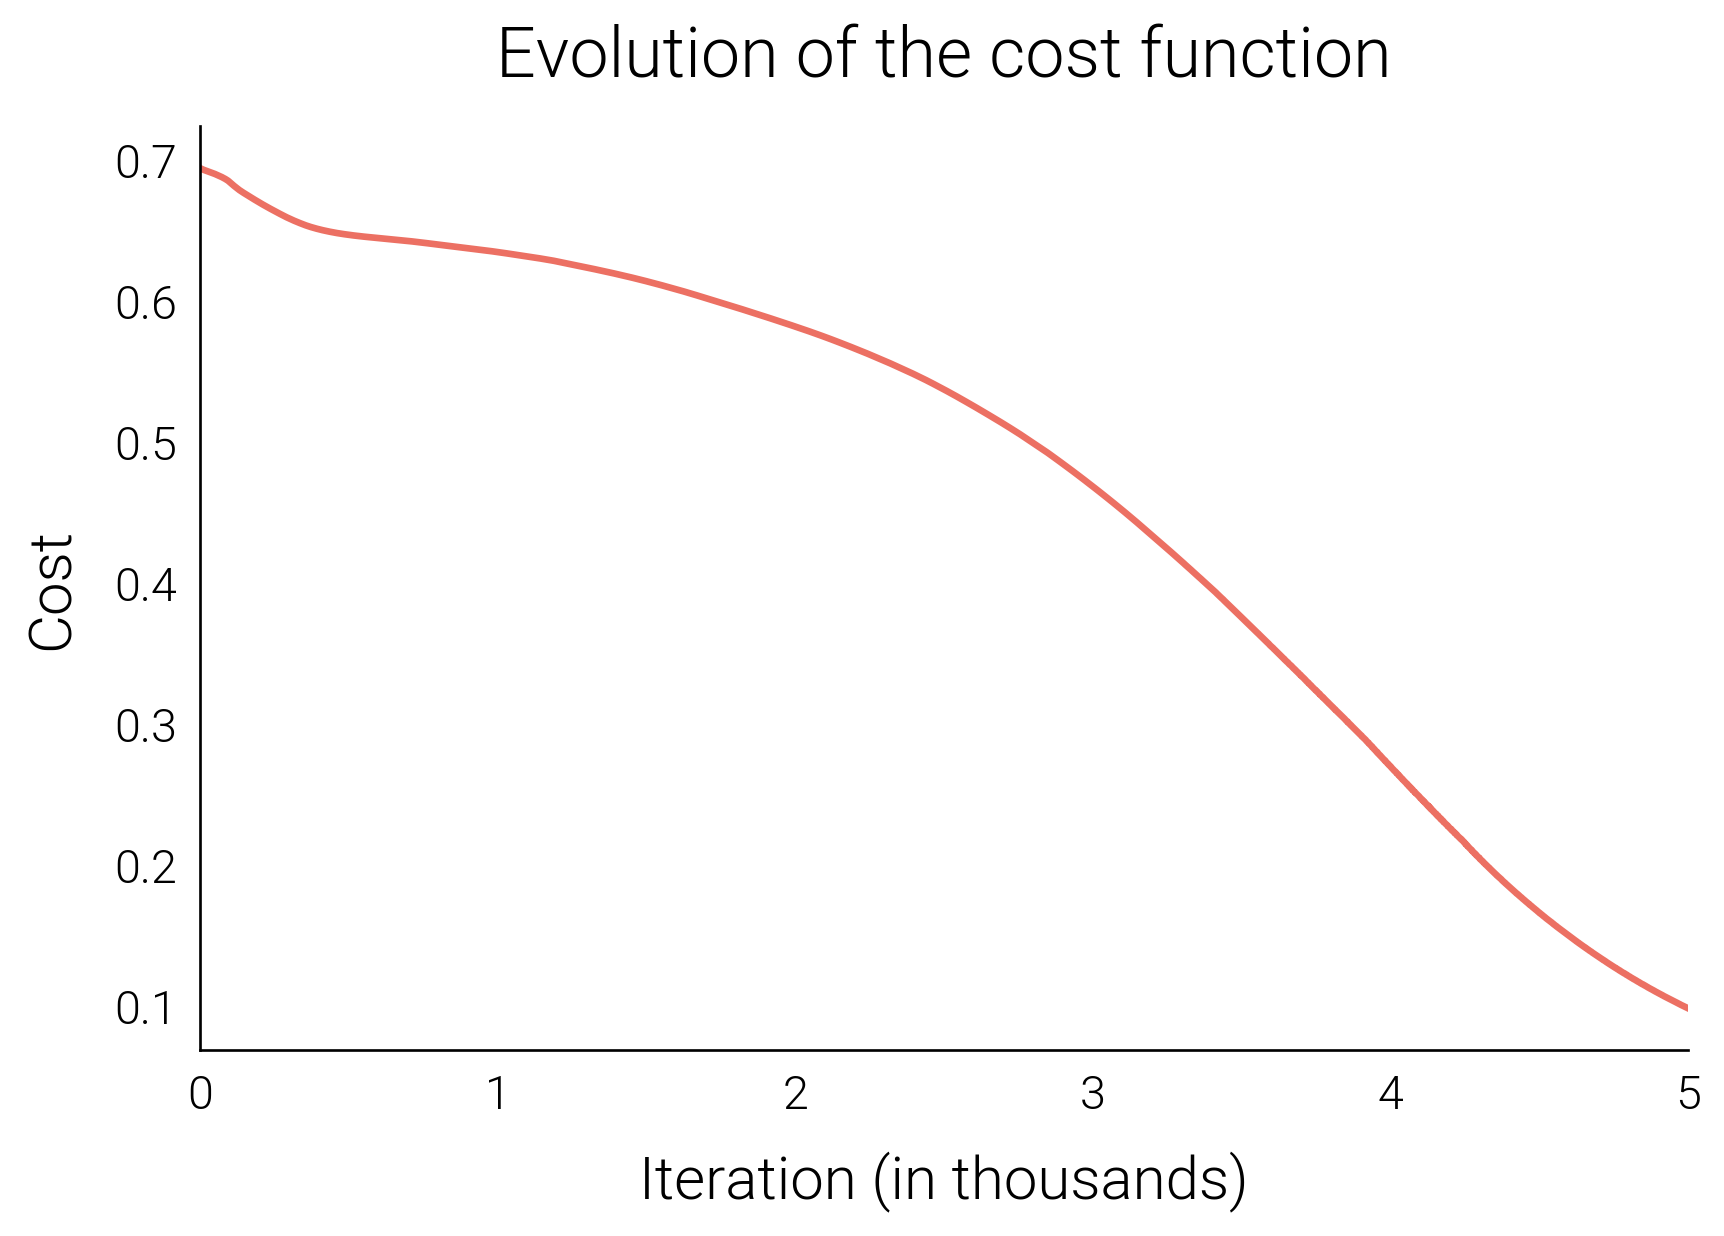

CPU times: user 3min 10s, sys: 1.53 s, total: 3min 12s
Wall time: 24.2 s


In [21]:
%%time
# Training the model on the train dataset of cat photos.
costs, parameters_trained = gradient_descent(train_x,train_y,parameters, learning_rate=0.0015,iterations= 5000)

In [22]:
# Testing model with train dataset
predictions = predict(train_x,parameters_trained)
acc = np.sum(train_y == predictions)/train_y.shape[1]*100
print(f'Our model has a train accuracy of {acc:.0f}%.')

Our model has a train accuracy of 100%.


Our model has a test accuracy of 82%.


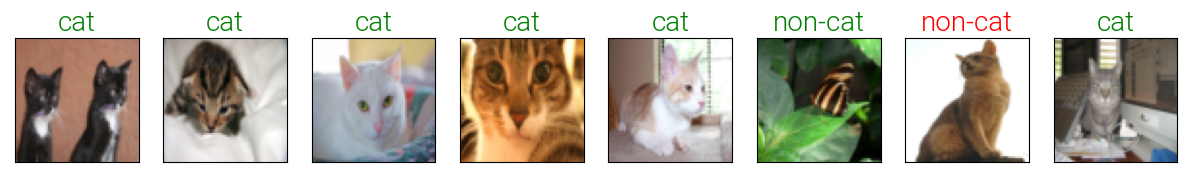

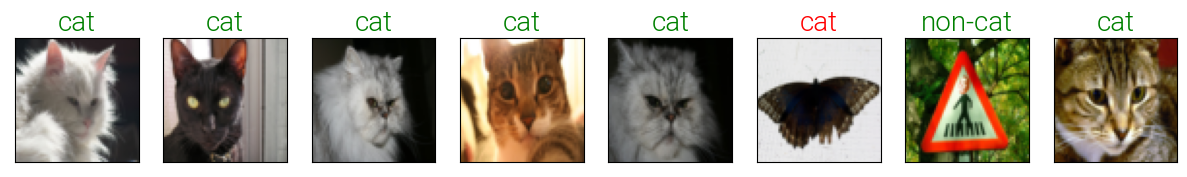

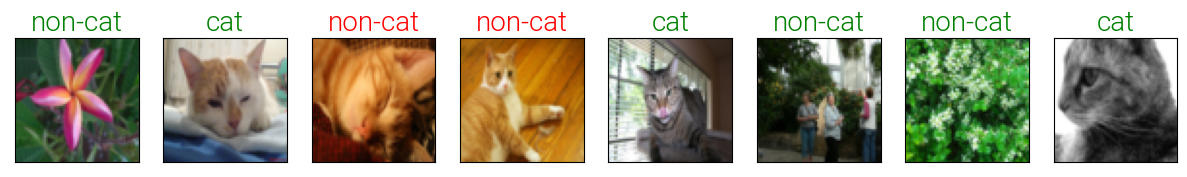

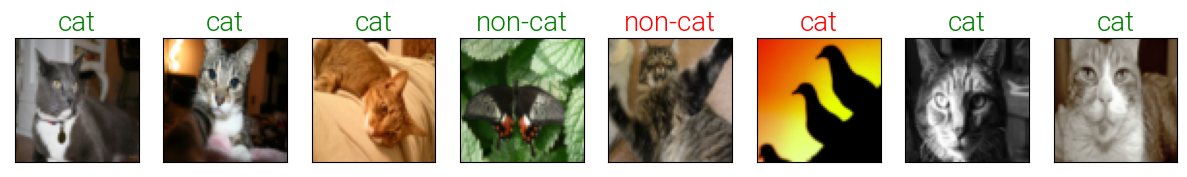

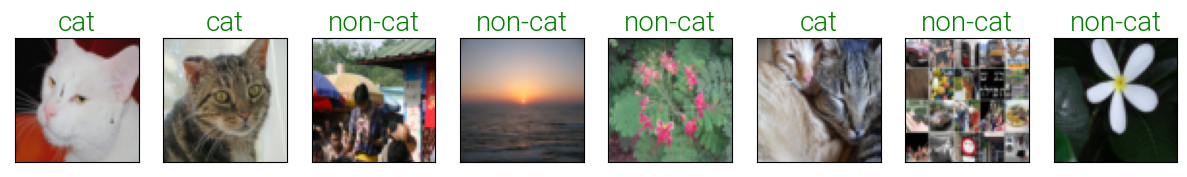

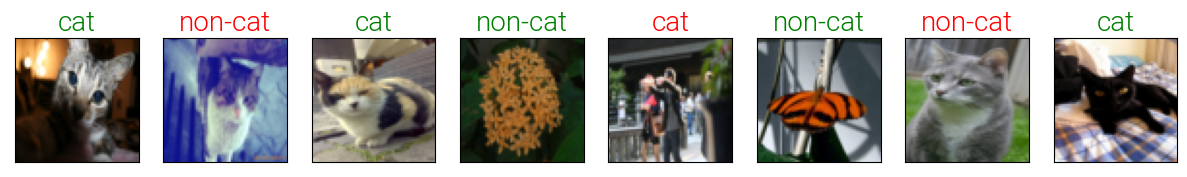

In [23]:
# Testing model with Test dataset
count = 0
predictions = predict(test_x,parameters_trained)
predictions_string = np.where(predictions==1, 'cat','non-cat')
color = np.where(predictions[0] == test_y[0], 'green', 'red')
acc = np.sum(test_y == predictions)/test_y.shape[1]*100
print(f'Our model has a test accuracy of {acc:.0f}%.')

for i in range(1,7):
    fig, ax = plt.subplots(1, 8,figsize=(15,15))
    for j in range (1,9):
        image = Image.fromarray(test_x_orig[count])
        ax[j-1].imshow(image)
        ax[j-1].set_xticks([])
        ax[j-1].set_yticks([])
        ax[j-1].set_title(predictions_string[0][j+8*(i-1)-1],color=color[j+8*(i-1)-1],fontsize=20)
        count += 1
    plt.show()